In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from utility import analysis_parameters as ap, util
import numpy as np
import dask
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

colors=ap.COLORS

In [2]:
plot_z = True
plot_theta = False

In [3]:
region="TWP"
# chunk_dict={"time":50, "ncol":2000, "lev":50}
chunks={"time": 5, "ncol":1200, "Xdim":1000, "cell":1000, "rgrid":1000}
ndays = 5
models = ["ICON","ARP","SHiELD", "UM"]
plt.rcParams["font.size"]=12

In [4]:
# vertical levels in the TTL
# m="IFS"
# z = xr.open_dataset("/work/ka1081/DYAMOND_WINTER/ECMWF/IFS-4km/DW-CPL/atmos/3hr/pa/r1i1p1f1/ml/sp/pa_3hr_IFS-4km_DW-CPL_r1i1p1f1_ml_sp_20200130000000-20200130210000.nc", 
#                     ).isel(time=4).pa[:,0,0]#.mean(dim=["cell"])
# z.plot.line(marker="o")
# # plt.ylim([14000,18000])
# plt.ylim([7000,15000])
# plt.show()

## functions


In [4]:
# functions
def get_esi(t):
    return (611.21 * np.exp(22.587*t/(t+273.86)))

def get_es(t):
    return (610.94 * np.exp(17.625*t/(t+243.04)))

def get_qs(es, p):
    return 0.622*es/p

def q2rhi(t, p, q, **kwargs):
    """
    Returns xarray of relative humidity wrt ice
    rhi = q/qs*100
    qsi = 0.622*es/P
    esi = 611.21 exp(22.587*T/(T+273.86)) for T <  0C
    """
    t = t - 273.15 # convert to deg C
    esi = get_esi(t)
    qsi = get_qs(esi, p)
    rh = q/qsi * 100
    return rh

def q2rh(t, p, q, **kwargs):
    """
    Returns xarray of relative humidity wrt liquid
    rh = q/qs*100
    qs = 0.622*es/P
    es = 610.94 exp(17.625*T/(T+243.04)) for T >= 0C
    """
    t = t - 273.15 # convert to deg C
    es = get_es(t)
    qs = get_qs(es, p)
    rh = q/qs * 100
    return rh

def q2wc(t, p, q, qi, **kwargs):
    """
    Returns xarray of ice or liquid water content
    iwc = qi * rho
    """
    rho = calc_rho(t, p, q)
    return (qi*rho)

def calc_rho(t, p, q):
    Tv = (1 + 0.61*q)*t
    rho = p / (287*Tv)
    return rho

def pot_temp(t, p):
    """ Returns potential temperature (theta in K)
        Input t (K) and p (Pa)
    """
    Rd = 287 # J/K/kg
    cp = 1004 # J/K/kg
    theta = t * np.power(100000/p, Rd/cp)
    return theta

def eq_pot_temp(t, p, q):
    """ Returns equivalent potential temperature (thetae in K)
        Input t (K), p (Pa) and q (kg/kg)
    """
    theta = pot_temp(t,p)
    Lv = 2.25e6 # J/kg
    cp = 1004 # J/K/kg
    qsi = get_qsi(get_esi(t), p)
    thetae = theta * np.exp(Lv * qsi / (cp * t) )
    return thetae


# vertical profiles of temp, RHi, and cld condensate

In [10]:
era_t = xr.open_dataset(ap.TWP+"ERA5_T_0.25deg_ml_12-20km_Feb2020_TWP.nc").isel(time=slice(-(5*24),-1))['t']
era_t.level

<xarray.DataArray 'level' (level: 30)>
array([49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78], dtype=int32)
Coordinates:
  * level    (level) int32 49 50 51 52 53 54 55 56 ... 71 72 73 74 75 76 77 78
Attributes:
    long_name:  model_level_number

In [ ]:
# plot temperature, relative humidity, and cloud ice in height coordinates
if plot_z:
    fig, ax = plt.subplots(1,4, figsize=(12,6), sharey=True)
    # add era5 ml reanalysis - hourly data
    # era_t = xr.open_dataset(ap.TWP+"ERA5_T_0.25deg_ml_12-20km_Feb2020_TWP.nc").isel(time=slice(-(5*24),-1))['t']
    for i,m in enumerate(models):
        if m=="UM":
            axes=(0,2,3)
        else:
            axes=(0,2)
        t = xr.open_dataset(ap.get_file(m, region+"_3D", "ta"), 
                        chunks=chunks).isel(time=slice(-8*ndays,-1)).ta[:,1:]
        tinit = xr.open_dataset(ap.get_file(m, region+"_3D", "ta"), 
                        chunks=chunks).isel(time=slice(0,8*ndays)).ta[:,1:]
        print(i,m, t.shape, t.dims)
        if m=="SCREAM":
            p = t.lev*100 # convert to Pa
        elif m=="UM" or m=="SHiELD" or m=="ICON" or m=="ARP":
            p = xr.open_dataset(ap.get_file(m, region+"_3D", "pa"), 
                        chunks=chunks).isel(time=slice(-8*ndays,-1)).pa[:,1:]
        elif m=="GEOS":
            p = xr.open_dataset(ap.get_file(m, region+"_3D", "pfull"), 
                        chunks=chunks).isel(time=slice(-8*ndays,-1)).pthick[1:]
            print(p.mean(axis=axes).values)
        else:
            raise Exception("model pres not defined yet")
        qv = xr.open_dataset(ap.get_file(m, region+"_3D", "hus"), 
                            chunks=chunks).isel(time=slice(-8*ndays,-1)).hus[:,1:]

        rhi = util.q2rhi(t, p, qv)
        rhi = rhi.mean(axis=axes)
        del p, qv

        # iwc = xr.open_dataset(ap.get_file(m, region+"_3D", "totalwater"), 
        #                     chunks=chunks).isel(time=slice(-8*ndays,-1)).totalwater[:,1:]
        # iwc = iwc.mean(axis=axes)

        z = xr.open_dataset(ap.get_file(m, region+"_3D", "zg"), 
                        chunks=chunks).isel(time=slice(-8*ndays,-1)).zg
        z = z.mean(axis=axes)/1000
        if m=="SHiELD" or m=="GEOS":
            z = z[1:]
        print(z.shape)
        tmean = t.mean(axis=axes)
        tinitmean = tinit.mean(axis=axes)
        ax[0].plot(tmean, z, label=m, color=colors[m])
        del t
        ax[2].plot(rhi, z, label=m, color=colors[m])
        del rhi
        # ax[2].plot(iwc*1000, z, label=m, color=colors[m])
        # del iwc
        ax[1].plot(tmean-tinitmean, z, label=m, color=colors[m])
        del tmean, tinitmean
        cth = xr.open_dataset(file, chunks=chunk_dict)['cldtop_height1e-05']
        cth_hist, _ = np.histogram(cth.values.flatten(), bins=zbins)
        cth_hist = cth_hist/np.prod(np.shape(cth))
        ax[0,3].step(hist0[2:], zbins[2:-1], label=m, lw=2, where='pre', color=colors[m])
        ax[3].plot(cth_hist, z, label=m, color=colors[m])
    # xlims = [(180,305),(-4.5,4.5),(0,110)]
    xlims = [(180,250),(-4.5,4.5),(0,110)]
    xlabels= ["Temperature (K)", "Temperature drift (K)\n(last - first 5 days)", "Relative Humidity wrt ice (%)", "Cloud top height histogram"]   
    for i in range(4):
        ax[i].fill_between(xlims[i],14000,18000, color='gray', alpha=0.3)
        ax[i].set_xlabel(xlabels[i])
        ax[i].set_xlim(xlims[i])
        # ax[i].set_ylim([0,22])
        ax[i].set_ylim([10,20])
        ax[i].grid(True)
    ax[0].set_ylabel("Height (km)")
    ax[2].legend(bbox_to_anchor=(1, 0.5), loc='center left', ncol=1)
    fig.suptitle("Last "+str(ndays)+" days of simulation period")
    plt.savefig("../plots/{}/{}_intercomparison_last{}days_t-rhi-tdrift_UTLS.png".format(region, region, ndays), 
                bbox_inches='tight', pad_inches=1)
    plt.show()

0 ICON (39, 76, 195442) ('time', 'height', 'cell')
[########################################] | 100% Completed | 102.85 ms
[########################################] | 100% Completed | 307.07 ms
[########################################] | 100% Completed | 303.27 ms
[########################################] | 100% Completed | 713.29 ms
[########################################] | 100% Completed | 101.97 ms
[########################################] | 100% Completed | 202.40 ms
(76,)
[########################################] | 100% Completed | 51.94 s
[########################################] | 100% Completed | 27.06 s
[########################################] | 100% Completed | 356.94 s
[########################################] | 100% Completed | 26.23 s
[########################################] | 100% Completed | 174.81 s
[########################################] | 100% Completed | 26.50 s
1 ARP (39, 59, 202950) ('time', 'lev', 'rgrid')
[########################################

In [13]:
p = xr.open_dataset(ap.get_file("GEOS", region+"_3D", "pa"), 
                        chunks=chunks).isel(time=slice(-8*ndays,-1)).pa[:,1:]
p[:,:,22].values

[########################################] | 100% Completed | 101.14 ms


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

# Plot RHi and total cloud in potential temperature space

0 ICON (23, 76, 195442) ('time', 'height', 'cell')
[########################################] | 100% Completed | 102.91 ms
[########################################] | 100% Completed | 311.40 ms
[########################################] | 100% Completed | 202.37 ms
[########################################] | 100% Completed | 411.85 ms
[########################################] | 100% Completed | 102.12 ms
[########################################] | 100% Completed | 202.85 ms
[########################################] | 100% Completed | 102.24 ms
[########################################] | 100% Completed | 310.85 ms
[########################################] | 100% Completed | 101.98 ms
[########################################] | 100% Completed | 310.87 ms
[########################################] | 100% Completed | 25.95 s
[########################################] | 100% Completed | 4.36 sms
[########################################] | 100% Completed | 8.65 ss
[#################

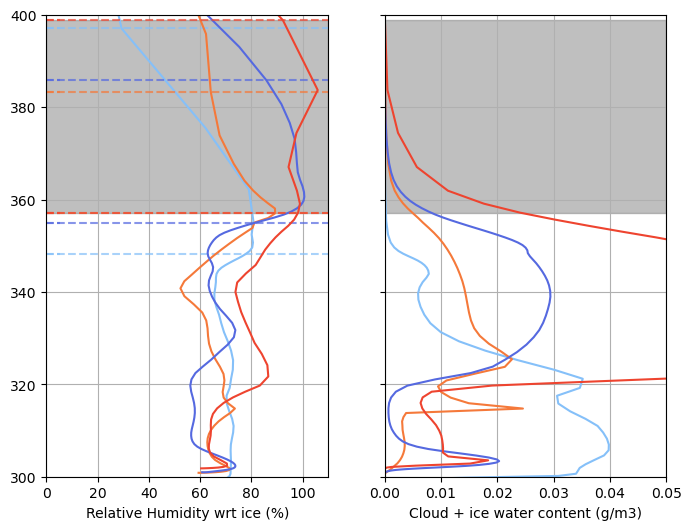

In [15]:
# plot relative humidity and cloud ice in temperature coordinates
if plot_theta:

    fig, ax = plt.subplots(1,2, figsize=(8,6), sharey=True)
    xlims = [(0,110),(0,0.05)]
    xlabels= ["Relative Humidity wrt ice (%)", "Cloud + ice water content (g/m3)"]
    
    for i,m in enumerate(models):
        if m=="UM":
            axes=(0,2,3)
        else:
            axes=(0,2)
            
        t = xr.open_dataset(ap.get_file(m, region+"_3D", "ta"), 
                            chunks=chunks).isel(time=slice(-8*ndays,-1)).ta[:,1:]
        print(i,m, t.shape, t.dims)
        if m=="SCREAM":
            p = t.lev*100 # convert to Pa
        elif m=="UM" or m=="SHiELD" or m=="ICON":
            p = xr.open_dataset(ap.get_file(m, region+"_3D", "pa"), 
                        chunks=chunks).isel(time=slice(-8*ndays,-1)).pa[:,1:]
        else:
            raise Exception("model pres not defined yet")
        qv = xr.open_dataset(ap.get_file(m, region+"_3D", "hus"), 
                            chunks=chunks).isel(time=slice(-8*ndays,-1)).hus[:,1:]

        rhi = q2rhi(t, p, qv)
        rhi = rhi.mean(axis=axes)
        del qv
        theta = pot_temp(t, p).mean(axis=axes)
        del t, p
        
        ax[0].plot(rhi, theta, label=m, color=colors[m])
        del rhi
        
        iwc = xr.open_dataset(ap.get_file(m, region+"_3D", "totalwater"), 
                            chunks=chunks).isel(time=slice(-8*ndays,-1)).totalwater[:,1:]
        iwc = iwc.mean(axis=axes)
        ax[1].plot(iwc*1000, theta, label=m, color=colors[m])
        del iwc
        
        z = xr.open_dataset(ap.get_file(m, region+"_3D", "zg"), 
                        chunks=chunks).isel(time=slice(-8*ndays,-1)).zg
        z = z.mean(axis=axes)
        
        ax[0].axhline(theta[np.argmin(abs(z.values-14000))],0,xlims[0][1], 
                      color=colors[m], linestyle="dashed", alpha=0.7)
        ax[0].axhline(theta[np.argmin(abs(z.values-18000))],0,xlims[0][1], 
                      color=colors[m], linestyle="dashed", alpha=0.7)
        ax[0].axhline(theta[np.argmin(abs(z.values-14000))],0,xlims[1][1], 
                      color=colors[m], linestyle="dashed", alpha=0.7)
        ax[0].axhline(theta[np.argmin(abs(z.values-18000))],0,xlims[1][1], 
                      color=colors[m], linestyle="dashed", alpha=0.7)

    
    for i in range(2):
        ax[i].fill_between(xlims[i],theta[np.argmin(abs(z.values-14000))],
                           theta[np.argmin(abs(z.values-18000))], color='gray', alpha=0.5)
        ax[i].set_xlabel(xlabels[i])
        ax[i].set_xlim(xlims[i])
        ax[i].set_ylim([300,400])
        ax[i].grid(True)
    plt.savefig("../plots/{}_intercomparison_last{}days_theta-rhi-qi.png".format(region, ndays))
    plt.show()

# old stuff


In [3]:
# m = "UM"
# xr.open_dataset(ap.get_fldmean_file(m, region, "cltotal")).cltotal
# da = xr.open_dataset(ap.TWP+"mean/fldmean_TWP_3D_SHiELD_zg_20200130-20200228.nc").zg.mean(axis=(0,2))
# ds = xr.Dataset({"zg":da}, attrs={"long_name":"spatiotemporal mean of geopotential height", "units":"m"})
# ds.to_netcdf(ap.TWP+"mean/xytmean_TWP_3D_SHiELD_zg_20200130-20200228.nc")

In [18]:
models=["SCREAM","ARP","ICON","UM","SHiELD"]
var="cl_5e-7kgm-3"
varw = "totalwater"
# models=["SCREAM", "SAM", "GEOS", "ICON", "UM", "ARP", "SHiELD"] # 
# var="cl_5e-7kgkg-1"
# varw="cltotal"

## create dictionaries with models as keys for each variable 
## temp & water vapor content
# ta_dict = dict(zip(models, [xr.open_dataset(ap.get_fldmean_file(m, region, "ta")).ta.median(axis=(0,2,3)) for m in models]))
# hus_dict = dict(zip(models, [xr.open_dataset(ap.get_fldmean_file(m, region, "hus")).hus.median(axis=(0,2,3)) for m in models]))
### SAM has qv in g/kg - convert to kg/kg
# hus_dict["SAM"] = hus_dict["SAM"]/1000

cltotal_dict = {}
cl_dict = {}
z_dict = {}
for m in models:
    print(m)
    if (m=="SAM") or (m=="UM"):
        axtup = (0,2,3)
        axtup2 = axtup
    else: # elif (m=="ARP") or (m=="SHiELD"):
        axtup = (0,2)
        axtup2 = axtup
    # else:
    #     axtup = (0,2)
    #     axtup2 = (0,2,3)
    ## get total frozen hydrometeors & cloud fraction
    cltotal_dict[m] = xr.open_dataset(ap.get_fldmean_file(m, region, varw))[varw].mean(axis=axtup)
    cl_dict[m] = xr.open_dataset(ap.get_fldmean_file(m, region, var)).cl.mean(axis=axtup2)
    if (m=="SCREAM") or (m=="ICON") or (m=="ARP") or (m=="UM"):
        cltotal_dict[m] = cltotal_dict[m][1:]
        cl_dict[m] = cl_dict[m][1:]        
    ## get height variables
    if m=="SAM":
        z_dict[m] = cl_dict["SAM"].z.rename({"z":"zg"})
        cltotal_dict["SAM"] = cltotal_dict["SAM"]/1000
    else:
        z_dict[m] = xr.open_dataset(ap.get_xytmean_file(m,"TWP","zg")).zg
    print(m, cltotal_dict[m].shape, cl_dict[m].shape, z_dict[m].shape)

## add in observations - DARDAR
ds = xr.open_dataset("/work/bb1153/b380883/TWP/twp.nc")
cltotal_dict["DARDAR"] = ds.iwc.mean(axis=0)/1000
cl_dict["DARDAR"] = np.where(ds.iwc>5e-4,1,0).mean(axis=0)
models=["DARDAR"]+models
z_dict["DARDAR"] = ds.height
print("DARDAR", cltotal_dict["DARDAR"].shape, cl_dict["DARDAR"].shape, z_dict["DARDAR"].shape)
## add in observations - CCCM
ds = xr.open_dataset("/work/bb1153/b380883/TWP/CCCM_dTWP_2007-2010.nc")
cl_dict["CCCM"] = ds["Cloud fraction (CALIPSO-CloudSat)"].mean(axis=0)
cltotal_dict["CCCM"] = (ds["iwc used in CERES radiation, avg over cloudy part of CERES footprint"]+\
                        ds["lwc used in CERES radiation, avg over cloudy part of CERES footprint"]).mean(axis=0)/1000
models=["CCCM"]+models
z_dict["CCCM"] = ds.alt*1000
print("CCCM", cltotal_dict["CCCM"].shape, cl_dict["CCCM"].shape, z_dict["CCCM"].shape)

# big_dict = {"cltotal":cltotal_dict, "cl":cl_dict, "z":z_dict}
print("...done")

SCREAM
SCREAM (127,) (127,) (127,)
ARP
ARP (59,) (59,) (59,)
ICON
ICON (76,) (76,) (76,)
UM
UM (54,) (54,) (54,)
SHiELD
SHiELD (79,) (79,) (79,)
DARDAR (436,) (436,) (436,)
CCCM (92,) (92,) (92,)
...done


In [19]:
print(" model \t  14km \t \t  18km \t \t n")
print("-------------------------------------------------")

for m in models:
    z = z_dict[m].values
    i14 = np.argmin(abs(z-14000))
    i18 = np.argmin(abs(z-18000))
    print(m+"\t {} {:.2f} \t {} {:.2f} \t {}".format(i14, z[i14], i18, z[i18], (i18-i14)))
    

 model 	  14km 	 	  18km 	 	 n
-------------------------------------------------
CCCM	 22 13920.00 	 5 18000.00 	 -17
DARDAR	 185 13980.00 	 118 18000.00 	 -67
SCREAM	 47 13909.74 	 29 17910.05 	 -18
ARP	 12 13944.95 	 3 18133.93 	 -9
ICON	 30 14015.83 	 22 18167.51 	 -8
UM	 43 14079.88 	 49 18026.52 	 6
SHiELD	 22 14064.95 	 14 18157.68 	 -8


## Cloud fraction & total cloud condensate

SCREAM uses 1e-5 kg/kg for their cloud mask - to be consistent we will use this as well.

In [20]:
## for comparison purposes
# cl_ge = xr.open_dataset("/work/bb1153/b380883/TWP/mean/fldmean_TWP_3D_GEOS_cl_modeloutput_20200130-20200228.nc").cl.mean(axis=(0,2,3))

# plt.plot(cl_ge, z_dict["GEOS"], color=colors["GEOS"], label=m, lw=2)
# plt.plot(cl_dict["GEOS"], z_dict["GEOS"], color=colors["GEOS"], label=m, lw=1)
# plt.ylim([0,20000])
# plt.show()

CCCM
DARDAR
SCREAM
ARP
ICON
UM
SHiELD


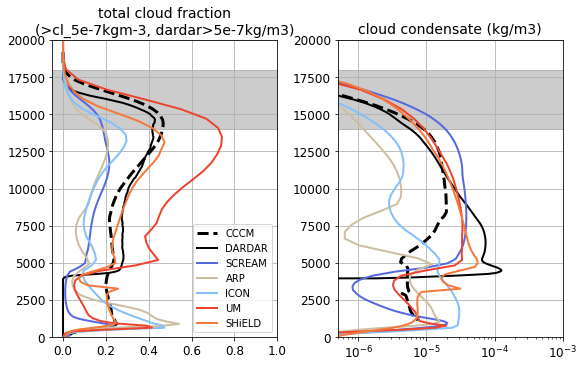

In [23]:
fig, [ax, axt] = plt.subplots(1,2, figsize=(8,5), constrained_layout=True)
emph="CCCM" # specific which model to emphasize by making the line thicker

#### plot each model ####
for i,m in enumerate(models):
    print(m)
    if (m=="CCCM") or (m=="DARDAR"):
        mc = "OBS"
    else:
        mc=m
    if emph==m:
        ls = "--"
        lw = 3
    else:
        ls = "-"
        lw = 2
    ax.plot(cl_dict[m], z_dict[m], color=colors[mc], label=m, linestyle=ls, lw=lw)
    axt.plot(cltotal_dict[m], z_dict[m], color=colors[mc], linestyle=ls, lw=lw)
    
    ## Add in freezing level
    # i_frz = np.argmin(abs(ta_dict[m].values-273))
    # ax.scatter(cl_dict[m][i_frz], z_dict[i_frz], color=colors[mc], alpha=0.6, marker="s")
    # axt.scatter(cltotal_dict[m][i_frz], z_dict[i_frz], color=colors[mc], alpha=0.6, marker="s")

## add in the TTL as a shaded region, title, and grid lines
ax.fill_between([-0.1,1],14000,18000,color="k",alpha=0.2)
ax.set_title("total cloud fraction\n(>{}, dardar>5e-7kg/m3)".format(var), fontsize=14)
ax.grid()
axt.fill_between([-1,0.6],14000,18000,color="k",alpha=0.2)
units = "kg/kg" if varw=="cltotal" else "kg/m3"
axt.set_title("cloud condensate ({})".format(units), fontsize=14)
axt.grid()

# set axis properties
ax.set_xlim([-0.05,1])
ax.set_ylim([0,20000])
ax.tick_params(labelsize=12)
axt.set_xlim([5e-7,1e-3])
axt.set_xscale("log")
axt.set_ylim([0, 20000])
axt.tick_params(labelsize=12)

ax.legend(loc="lower right")

# save figure
plt.savefig("../plots/TWP/TWP_3D_{}_{}.png".format(var, varw), dpi=120)

plt.show()